In [1]:
import numpy as np
import xarray as xa
from matplotlib import pyplot as plt
from scipy.stats import gamma, genpareto, norm
from scipy import optimize
import matplotlib

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

data = xa.open_dataarray(
    "/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))

# Fit Function

In [3]:
def genpareto_objective_fn(theta, x, dis_func):
    scale = theta[-1]
    loc = 1 # starts from 1
    x = (np.asarray(x)-loc) / scale
    a = theta[0]
    args = (a, scale)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    return -np.sum(logpdf, axis=0)

def genpareto_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    logpdf = dis_func.logpdf(x, a, loc=0, scale=scale)
    finite_logpdf = np.isfinite(logpdf)
    # print(np.sum(finite_logpdf))
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def genpareto_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 1
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a<0:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return genpareto_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_genpareto_parameters(data, dis_func):
    function = genpareto_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args

In [4]:
def gamma_objective_fn(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = args[0]
    scale = theta[-1]
    loc = 0 # starts from 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func)

def gamma_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a, scale=1)/scale
    total_pdf = 1 - dis_func.cdf(1, a, loc=0, scale=scale) # from 1 to inf
    pdf = pdf/total_pdf
    logpdf = np.log(pdf)
    finite_logpdf = np.isfinite(logpdf)
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def gamma_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a>1:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_gamma_parameters(data, dis_func):
    function = gamma_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args

In [5]:
def fit_gamma_genpareto(data, ax, x):
    a1, scale1 = fit_gamma_parameters(data, gamma)
    pdf1 = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
    score_ga = gamma_objective_fn(x=data, theta=(a1, scale1), dis_func=gamma)
    # print('Gamma: ', score_ga)
    if ax is not None:
        ax.plot(x, pdf1, color='red')
    a2, scale2 = fit_genpareto_parameters(data, genpareto)
    pdf2 = genpareto.pdf(x, a2, 1, scale2)
    score_gp = genpareto_objective_fn(x=data, theta=(a2, scale2), dis_func=genpareto)
    # print('GenPareto: ', score_gp)
    if ax is not None:
        ax.plot(x, pdf2, color='blue', label='GenPareto')
    return (a1, scale1), (a2, scale2), np.max([pdf2, pdf1]), (score_ga, score_gp)

In [6]:
def sub_single(sub_id):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    tc_precip = []
    mcs_precip = []
    midtro_precip = []
    front_precip = []
    surge_precip = []
    
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0:
            tc_precip.append(sub_precip[i])
        if surge_sub[i]>0:
            surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        if front_sub[i]>0:
            front_precip.append(sub_precip[i])
        if midtro_sub[i]>0:
            midtro_precip.append(sub_precip[i])
        
    
    return [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]

In [7]:
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
names = ['MCS', 'TC', 'Surge', 'Front', 'Midtro', 'UTT']

In [8]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip] = sub_single(sub_id=1)

In [9]:
def get_precip(sub_id):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    tc_precip = []
    mcs_precip = []
    midtro_precip = []
    front_precip = []
    surge_precip = []
    # two-way
    tc_tutt_precip = []
    tc_mcs_precip = []
    tc_surge_precip = []
    tc_front_precip = []
    tc_midtro_precip = []
    tutt_mcs_precip = []
    tutt_surge_precip = []
    tutt_midtro_precip = []
    tutt_front_precip = []
    mcs_midtro_precip = []
    mcs_front_precip = []
    mcs_surge_precip = []
    midtro_front_precip = []
    midtro_surge_precip = []
    front_surge_precip = []
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0:
            tc_precip.append(sub_precip[i])
        if surge_sub[i]>0:
            surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        if front_sub[i]>0:
            front_precip.append(sub_precip[i])
        if midtro_sub[i]>0:
            midtro_precip.append(sub_precip[i])
        # 2-way
        if midtro_sub[i]>0 and front_sub[i]>0:
            midtro_front_precip.append(sub_precip[i])
        if midtro_sub[i]>0 and surge_sub[i]>0:
            midtro_surge_precip.append(sub_precip[i])
        if surge_sub[i]>0 and front_sub[i]>0:
            front_surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and front_sub[i]>0:
            mcs_front_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and midtro_sub[i]>0:
            mcs_midtro_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and surge_sub[i]>0:
            mcs_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and tutt_sub[i]>0:
            tc_tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0 and front_sub[i]>0:
            tc_front_precip.append(sub_precip[i])
        if tc_sub[i]>0 and surge_sub[i]>0:
            tc_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and midtro_sub[i]>0:
            tc_midtro_precip.append(sub_precip[i])
        if tc_sub[i]>0 and mcs_sub[i]>0:
            tc_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and front_sub[i]>0:
            tutt_front_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and mcs_sub[i]>0:
            tutt_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and surge_sub[i]>0:
            tutt_surge_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and midtro_sub[i]>0:
            tutt_midtro_precip.append(sub_precip[i])
        two_way_precip = [tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
                      tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
                      mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
                      midtro_front_precip, midtro_surge_precip,
                      front_surge_precip,]
    return [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
            two_way_precip

# Sub1

In [10]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=1)

## TC

In [11]:
print(len(tc_precip))
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))

227
208
24
2
42
56


In [12]:
def get_pdf(precip, x):
    (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
    if score_ga<score_gp:
        pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
        dis = 'Gamma'
        # print(a1, scale1)
    else:
        pdf = genpareto.pdf(x, a2, 1, scale2)
        dis = 'GenPareto'
        # print(a2, scale2)
    return pdf

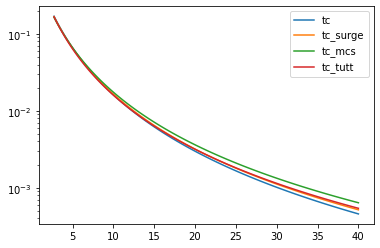

In [13]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
pdf_tc = get_pdf(tc_precip, x)
plt.plot(x, pdf_tc, label='tc')
pdf_tc_surge = get_pdf(tc_surge_precip, x)
plt.plot(x, pdf_tc_surge, label='tc_surge')
pdf_tc_mcs = get_pdf(tc_mcs_precip, x)
plt.plot(x, pdf_tc_mcs, label='tc_mcs')
pdf_tc_tutt = get_pdf(tc_tutt_precip, x)
plt.plot(x, pdf_tc_tutt, label='tc_tutt')

plt.legend()
plt.yscale('log')

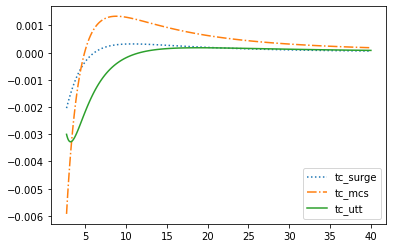

In [14]:
plt.plot(x, pdf_tc_surge-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_surge')
plt.plot(x, pdf_tc_mcs-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_mcs')
plt.plot(x, pdf_tc_tutt-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_utt')

plt.legend()
# plt.yscale('log')
plt.show()

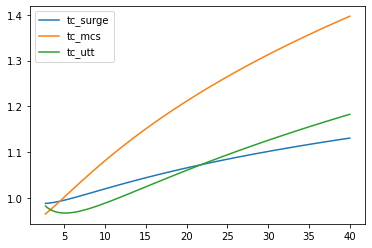

In [15]:
plt.plot(x, pdf_tc_surge / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_surge')
plt.plot(x, pdf_tc_mcs / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_mcs')
plt.plot(x, pdf_tc_tutt / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_utt')

plt.legend()
# plt.yscale('log')
plt.show()

* Surge and MCS increase TC, UTT decrease TC

# Sub7

## TC

In [16]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=7)

In [17]:
print(len(tc_precip))
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))

178
160
9
14
50
50


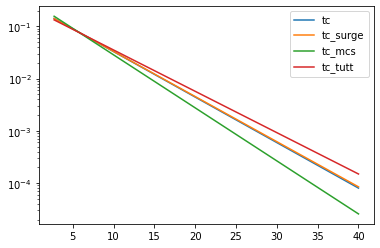

In [18]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
pdf_tc = get_pdf(tc_precip, x)
plt.plot(x, pdf_tc, label='tc')
pdf_tc_surge = get_pdf(tc_surge_precip, x)
plt.plot(x, pdf_tc_surge, label='tc_surge')
pdf_tc_mcs = get_pdf(tc_mcs_precip, x)
plt.plot(x, pdf_tc_mcs, label='tc_mcs')
pdf_tc_tutt = get_pdf(tc_tutt_precip, x)
plt.plot(x, pdf_tc_tutt, label='tc_tutt')

plt.legend()
plt.yscale('log')

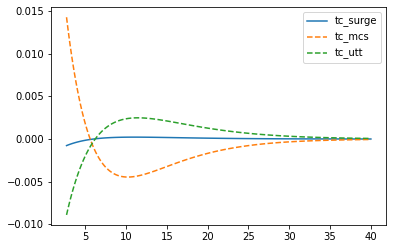

In [19]:
plt.plot(x, pdf_tc_surge-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_surge')
plt.plot(x, pdf_tc_mcs-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_mcs')
plt.plot(x, pdf_tc_tutt-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_utt')

plt.legend()
# plt.yscale('log')
plt.show()

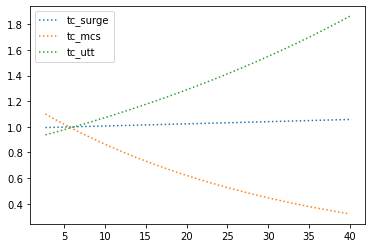

In [20]:
plt.plot(x, pdf_tc_surge / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_surge')
plt.plot(x, pdf_tc_mcs / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_mcs')
plt.plot(x, pdf_tc_tutt / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_utt')

plt.legend()
# plt.yscale('log')
plt.show()

* Surge doesn't change TC a lot. --> TC always trigger surges. 
* MCS UTT decrease TC. why mcs? 

In [21]:
e_tc = np.sum((x*pdf_tc))/np.sum(pdf_tc)
print(e_tc)
e_tc_tutt = np.sum((x*pdf_tc_tutt))/np.sum(pdf_tc_tutt)
print(e_tc_tutt)

5.6359803418183905
5.862150713983788


# Sub6

## TC

In [22]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=6)
sub_precip = monsoon_precip.sel(sub_id=6)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)

10.647874758983226


In [23]:
print(len(tc_precip))
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))

89
84
10
15
15
21


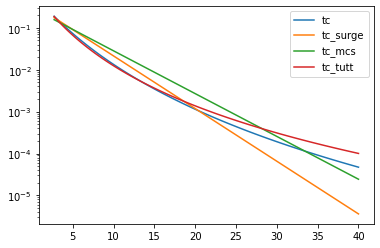

In [24]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
pdf_tc = get_pdf(tc_precip, x)
plt.plot(x, pdf_tc, label='tc')
pdf_tc_surge = get_pdf(tc_surge_precip, x)
plt.plot(x, pdf_tc_surge, label='tc_surge')
pdf_tc_mcs = get_pdf(tc_mcs_precip, x)
plt.plot(x, pdf_tc_mcs, label='tc_mcs')
pdf_tc_tutt = get_pdf(tc_tutt_precip, x)
plt.plot(x, pdf_tc_tutt, label='tc_tutt')

plt.legend()
plt.yscale('log')

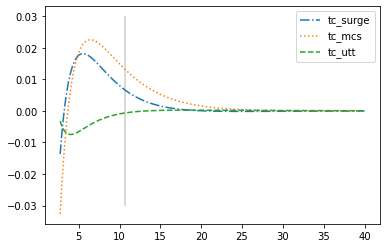

In [25]:
plt.plot(x, pdf_tc_surge-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_surge')
plt.plot(x, pdf_tc_mcs-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_mcs')
plt.plot(x, pdf_tc_tutt-pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_utt')
plt.vlines(threshold, ymin=-0.03, ymax=0.03, alpha=0.2, color='black')
plt.legend()
# plt.yscale('log')
plt.show()

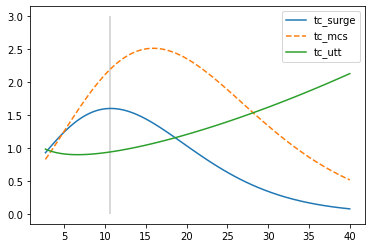

In [26]:
plt.plot(x, pdf_tc_surge / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_surge')
plt.plot(x, pdf_tc_mcs / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_mcs')
plt.plot(x, pdf_tc_tutt / pdf_tc, linestyle=linestyle_str[np.random.randint(10)%4], label='tc_utt')
plt.vlines(threshold, ymin=0, ymax=3, alpha=0.2, color='black')
plt.legend()
# plt.yscale('log')
plt.show()

* MCS increase TC

## midtro

In [27]:
print(len(midtro_surge_precip))
print(len(tutt_midtro_precip))
print(len(midtro_front_precip))
print(len(mcs_midtro_precip))
print(len(tc_midtro_precip))

38
22
11
6
10


## TUTT

In [28]:
print(len(tutt_mcs_precip))
print(len(tutt_surge_precip))
print(len(tutt_midtro_precip))
print(len(tutt_front_precip))
print(len(tc_tutt_precip))

307
697
22
172
21


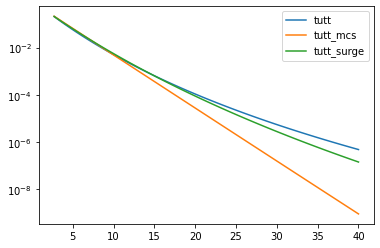

In [29]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
pdf_tutt = get_pdf(tutt_precip, x)
plt.plot(x, pdf_tutt, label='tutt')
pdf_tutt_mcs = get_pdf(tutt_mcs_precip, x)
plt.plot(x, pdf_tutt_mcs, label='tutt_mcs')
pdf_tutt_surge = get_pdf(tutt_surge_precip, x)
plt.plot(x, pdf_tutt_surge, label='tutt_surge')

plt.legend()
plt.yscale('log')

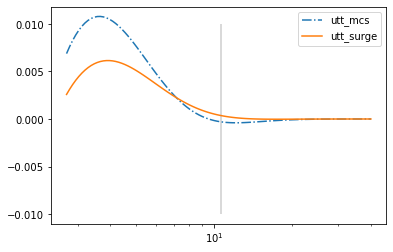

In [30]:
plt.plot(x, pdf_tutt_mcs-pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_mcs')
plt.plot(x, pdf_tutt_surge-pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_surge')
plt.vlines(threshold, ymin=-0.01, ymax=0.01, alpha=0.2, color='black')
plt.legend()
plt.xscale('log')
plt.show()

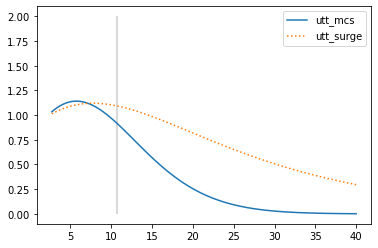

In [31]:
plt.plot(x, pdf_tutt_mcs / pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_mcs')
plt.plot(x, pdf_tutt_surge / pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_surge')
plt.vlines(threshold, ymin=-0, ymax=2, alpha=0.2, color='black')
plt.legend()
# plt.yscale('log')
plt.show()

* MCS increase utt

# Sub2

In [32]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=2)

## TC

In [33]:
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))

23
5
7
3
3


## Midtro

In [34]:
print(len(midtro_surge_precip))
print(len(tutt_midtro_precip))
print(len(midtro_front_precip))
print(len(mcs_midtro_precip))
print(len(tc_midtro_precip))

27
17
6
1
5


## TUTT

In [35]:
print(len(tutt_mcs_precip))
print(len(tutt_surge_precip))
print(len(tutt_midtro_precip))
print(len(tutt_front_precip))
print(len(tc_tutt_precip))

46
204
17
45
3


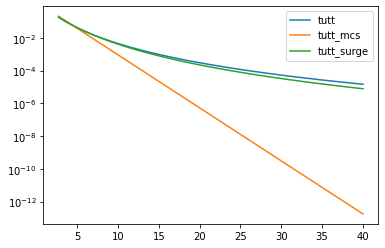

In [36]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
pdf_tutt = get_pdf(tutt_precip, x)
plt.plot(x, pdf_tutt, label='tutt')
pdf_tutt_mcs = get_pdf(tutt_mcs_precip, x)
plt.plot(x, pdf_tutt_mcs, label='tutt_mcs')
pdf_tutt_surge = get_pdf(tutt_surge_precip, x)
plt.plot(x, pdf_tutt_surge, label='tutt_surge')

plt.legend()
plt.yscale('log')

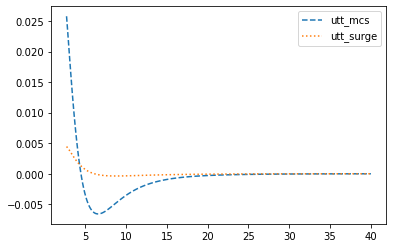

In [37]:
plt.plot(x, pdf_tutt_mcs-pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_mcs')
plt.plot(x, pdf_tutt_surge-pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_surge')

plt.legend()
# plt.yscale('log')
plt.show()

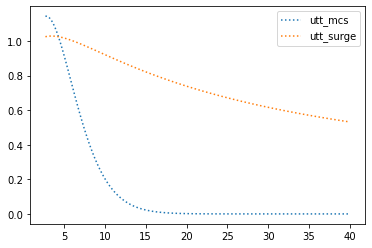

In [38]:
plt.plot(x, pdf_tutt_mcs / pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_mcs')
plt.plot(x, pdf_tutt_surge / pdf_tutt, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_surge')

plt.legend()
# plt.yscale('log')
plt.show()

# TC_Sub3

In [39]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=3)

In [40]:
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))

1
0
0
0
0


## Midtro

In [41]:
print(len(midtro_surge_precip))
print(len(tutt_midtro_precip))
print(len(midtro_front_precip))
print(len(mcs_midtro_precip))
print(len(tc_midtro_precip))

61
60
27
5
0


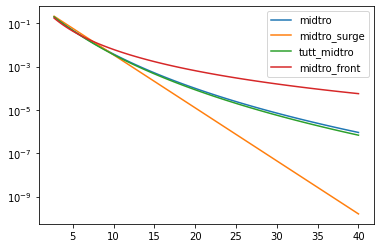

In [42]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
pdf_midtro = get_pdf(midtro_precip, x)
plt.plot(x, pdf_midtro, label='midtro')
pdf_midtro_surge = get_pdf(midtro_surge_precip, x)
plt.plot(x, pdf_midtro_surge, label='midtro_surge')
pdf_tutt_midtro = get_pdf(tutt_midtro_precip, x)
plt.plot(x, pdf_tutt_midtro, label='tutt_midtro')
pdf_midtro_front = get_pdf(midtro_front_precip, x)
plt.plot(x, pdf_midtro_front, label='midtro_front')

plt.legend()
plt.yscale('log')

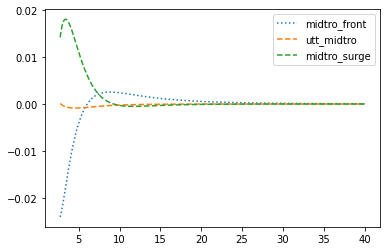

In [43]:
plt.plot(x, pdf_midtro_front-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.plot(x, pdf_tutt_midtro-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_midtro')
plt.plot(x, pdf_midtro_surge-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_surge')

plt.legend()
# plt.yscale('log')
plt.show()

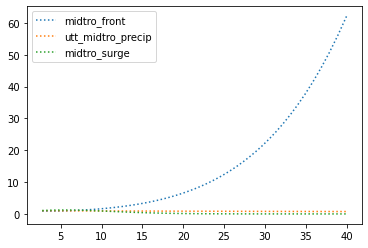

In [44]:
plt.plot(x, pdf_midtro_front / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.plot(x, pdf_tutt_midtro / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_midtro_precip')
plt.plot(x, pdf_midtro_surge / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_surge')

plt.legend()
# plt.yscale('log')
plt.show()

* Front will increase midtro

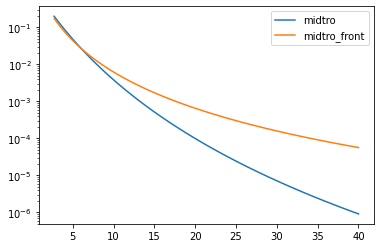

In [45]:
x = np.logspace(1, np.log(40), num=100, base=np.e)
plt.plot(x, pdf_midtro, label='midtro')
plt.plot(x, pdf_midtro_front, label='midtro_front')

plt.legend()
plt.yscale('log')

# TC_Sub4

In [46]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=4)
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))
sub_precip = monsoon_precip.sel(sub_id=4)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)

2
1
0
0
0
6.2968948209451305


## Midtro

In [47]:
print(len(midtro_surge_precip))
print(len(tutt_midtro_precip))
print(len(midtro_front_precip))
print(len(mcs_midtro_precip))
print(len(tc_midtro_precip))

87
105
70
15
1


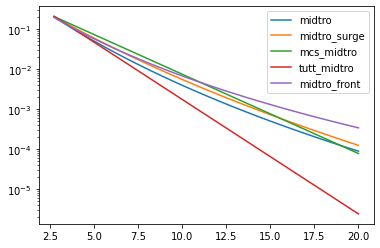

In [48]:
x = np.logspace(1, np.log(20), num=100, base=np.e)
pdf_midtro = get_pdf(midtro_precip, x)
plt.plot(x, pdf_midtro, label='midtro')
pdf_midtro_surge = get_pdf(midtro_surge_precip, x)
plt.plot(x, pdf_midtro_surge, label='midtro_surge')
pdf_mcs_midtro = get_pdf(mcs_midtro_precip, x)
plt.plot(x, pdf_mcs_midtro, label='mcs_midtro')
pdf_tutt_midtro = get_pdf(tutt_midtro_precip, x)
plt.plot(x, pdf_tutt_midtro, label='tutt_midtro')
pdf_midtro_front = get_pdf(midtro_front_precip, x)
plt.plot(x, pdf_midtro_front, label='midtro_front')

plt.legend()
plt.yscale('log')

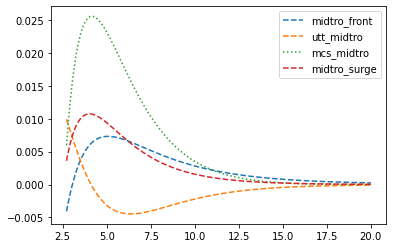

In [49]:
plt.plot(x, pdf_midtro_front-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.plot(x, pdf_tutt_midtro-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_midtro')
plt.plot(x, pdf_mcs_midtro-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='mcs_midtro')
plt.plot(x, pdf_midtro_surge-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_surge')

plt.legend()
# plt.yscale('log')
plt.show()

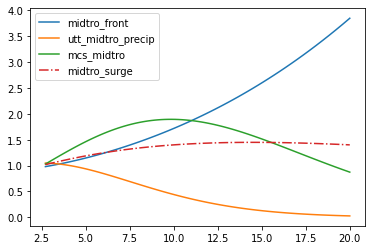

In [50]:
plt.plot(x, pdf_midtro_front / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.plot(x, pdf_tutt_midtro / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_midtro_precip')
plt.plot(x, pdf_mcs_midtro / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='mcs_midtro')
plt.plot(x, pdf_midtro_surge / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_surge')

plt.legend()
# plt.yscale('log')
plt.show()

* Front will increase midtro

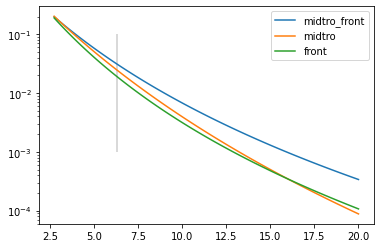

In [51]:
plt.plot(x, pdf_midtro_front, label='midtro_front')
plt.plot(x, pdf_midtro, label='midtro')
pdf_front = get_pdf(front_precip, x)
plt.plot(x, pdf_front, label='front')
plt.legend()
plt.vlines(threshold, ymin=0.001, ymax=0.1, alpha=0.2, color='black')
plt.yscale('log')
plt.show()

# TC_Sub5

In [52]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
midtro_front_precip, midtro_surge_precip,
front_surge_precip,] = get_precip(sub_id=5)
print(len(tc_surge_precip))
print(len(tc_midtro_precip))
print(len(tc_front_precip))
print(len(tc_mcs_precip))
print(len(tc_tutt_precip))
sub_precip = monsoon_precip.sel(sub_id=5)
sub_precip = sub_precip[sub_precip>1]
threshold = np.quantile(sub_precip, .95)
print(threshold)

28
8
15
3
10
6.469523059079158


## Midtro

In [53]:
print(len(midtro_surge_precip))
print(len(tutt_midtro_precip))
print(len(midtro_front_precip))
print(len(mcs_midtro_precip))
print(len(tc_midtro_precip))

87
84
43
21
8


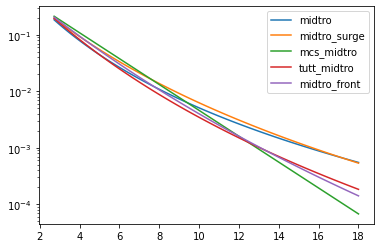

In [54]:
x = np.logspace(1, np.log(18), num=100, base=np.e)
pdf_midtro = get_pdf(midtro_precip, x)
plt.plot(x, pdf_midtro, label='midtro')
pdf_midtro_surge = get_pdf(midtro_surge_precip, x)
plt.plot(x, pdf_midtro_surge, label='midtro_surge')
pdf_mcs_midtro = get_pdf(mcs_midtro_precip, x)
plt.plot(x, pdf_mcs_midtro, label='mcs_midtro')
pdf_tutt_midtro = get_pdf(tutt_midtro_precip, x)
plt.plot(x, pdf_tutt_midtro, label='tutt_midtro')
pdf_midtro_front = get_pdf(midtro_front_precip, x)
plt.plot(x, pdf_midtro_front, label='midtro_front')

plt.legend()
plt.yscale('log')

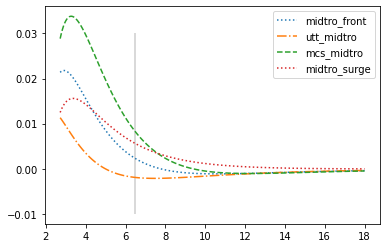

In [55]:
plt.plot(x, pdf_midtro_front-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.plot(x, pdf_tutt_midtro-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_midtro')
plt.plot(x, pdf_mcs_midtro-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='mcs_midtro')
plt.plot(x, pdf_midtro_surge-pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_surge')
plt.vlines(threshold, ymin=-0.01, ymax=0.03, alpha=0.2, color='black')
plt.legend()
# plt.yscale('log')
plt.show()

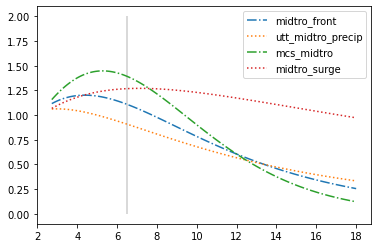

In [56]:
plt.plot(x, pdf_midtro_front / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.plot(x, pdf_tutt_midtro / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='utt_midtro_precip')
plt.plot(x, pdf_mcs_midtro / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='mcs_midtro')
plt.plot(x, pdf_midtro_surge / pdf_midtro, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_surge')
plt.vlines(threshold, ymin=-0, ymax=2, alpha=0.2, color='black')
plt.legend()
# plt.yscale('log')
plt.show()

* TUTT will increase Midtro

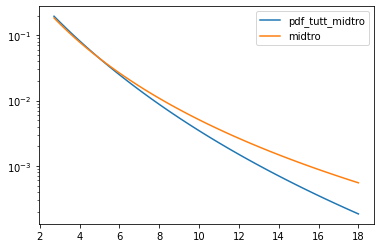

In [57]:
plt.plot(x, pdf_tutt_midtro, label='pdf_tutt_midtro')
plt.plot(x, pdf_midtro, label='midtro')
plt.legend()
plt.yscale('log')
plt.show()

## Front

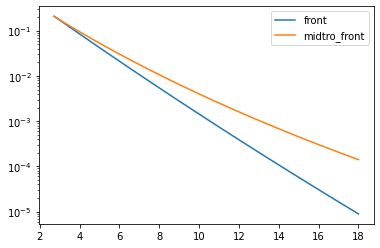

In [58]:
x = np.logspace(1, np.log(18), num=100, base=np.e)
pdf_front = get_pdf(front_precip, x)
plt.plot(x, pdf_front, label='front')
pdf_midtro_front = get_pdf(midtro_front_precip, x)
plt.plot(x, pdf_midtro_front, label='midtro_front')

plt.legend()
plt.yscale('log')

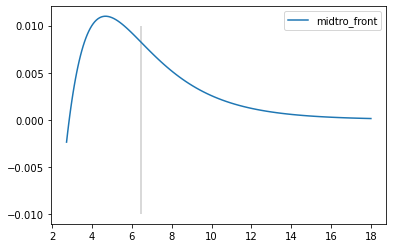

In [59]:
plt.plot(x, pdf_midtro_front-pdf_front, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.vlines(threshold, ymin=-0.01, ymax=0.01, alpha=0.2, color='black')
plt.legend()
# plt.yscale('log')
plt.show()

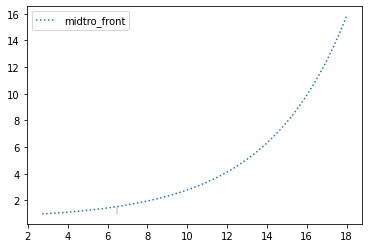

In [60]:
plt.plot(x, pdf_midtro_front / pdf_front, linestyle=linestyle_str[np.random.randint(10)%4], label='midtro_front')
plt.vlines(threshold, ymin=1, ymax=1.5, alpha=0.2, color='black')
plt.legend()
# plt.yscale('log')
plt.show()

* Midtro will increase front

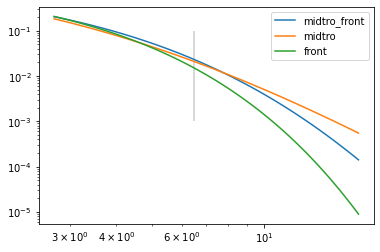

In [61]:
plt.plot(x, pdf_midtro_front, label='midtro_front')
plt.plot(x, pdf_midtro, label='midtro')
pdf_front = get_pdf(front_precip, x)
plt.plot(x, pdf_front, label='front')
plt.legend()
plt.vlines(threshold, ymin=0.001, ymax=0.1, alpha=0.2, color='black')
plt.yscale('log')
plt.xscale('log')
plt.show()